# Imports

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

from typing import Dict
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

# Helper functions

In [2]:
def get_metrics_for_network(directed_graph: nx.graph) -> Dict[str, int]:
    metrics = {}
    
    # For directed graph.
    n = len(directed_graph.nodes())
    e = len(directed_graph.edges())
    metrics['#nodes'] = n
    metrics['#edges'] = e
    metrics['#edges/#nodes'] = e / n
    metrics['in_degree'] = np.mean( list(nx.in_degree_centrality(directed_graph).values()) )
    metrics['out_degree'] = np.mean( list(nx.out_degree_centrality(directed_graph).values()) )
    metrics['degree'] = np.mean( list(nx.degree_centrality(directed_graph).values()) )
    metrics['load'] = np.mean( list(nx.load_centrality(directed_graph).values()) )
    metrics['eigenvector'] = np.mean( list(nx.eigenvector_centrality(directed_graph, max_iter=10000).values()) )
    metrics['harmonic'] = np.mean( list(nx.harmonic_centrality(directed_graph).values()) )
    metrics['closeness'] = np.mean( list(nx.closeness_centrality(directed_graph).values()) )
    metrics['betweenness'] = np.mean( list(nx.betweenness_centrality(directed_graph).values()) )
#     metrics['katz'] = np.mean( list(nx.katz_centrality(directed_graph, max_iter=10000).values()))
    # directed graphs' weights.
    weights = np.zeros(len(directed_graph.edges()))
    for i, edge in enumerate(directed_graph.edges()):
        weights[i] = directed_graph.get_edge_data(edge[0], edge[1])['weight']
    metrics['weights min'] = min(weights)
    metrics['weights max'] = max(weights)
    metrics['weights mean'] = np.mean(weights)
    metrics['weights std'] = np.std(weights)
    metrics['#pos edges'] = len(np.where(weights>0)[0])
    metrics['#neg edges'] = len(np.where(weights<0)[0])
    
    # For undirected version of the given directed graph.
    undirected_graph = nx.to_undirected(directed_graph)
    metrics['clustering_coefficient'] = np.mean( list(nx.clustering(undirected_graph)) )
    metrics['algebraic_connectivity'] = nx.algebraic_connectivity(undirected_graph, weight='weight')
    
    # For Giant Connected Component.
    GCC = max(nx.connected_component_subgraphs(undirected_graph), key = len)
    metrics['gcc'] = len(GCC.nodes())
    gcc_weights = np.zeros(len(GCC.edges()))
    for i, edge in enumerate(GCC.edges()):
        gcc_weights[i] = GCC.get_edge_data(edge[0], edge[1])['weight']
    metrics['#gcc pos edges'] = len(np.where(gcc_weights>0)[0])
    metrics['#gcc neg edges'] = len(np.where(gcc_weights<0)[0])
    return metrics

# Data loading

In [3]:
# Loads the csv file into a dataframe.
data = pd.read_csv('soc-sign-bitcoinalpha.csv', header=None)
# Sets the names of the columns.
data.columns = ['source', 'target', 'weight', 'time']
# Converts the datetime structure and sets in the dataframe.
converted_times = []
for row_index in range(len(data)):
    converted_times.append(
        datetime.datetime.fromtimestamp(data['time'][row_index]))
data['time'] = converted_times

# Sorts the data by time column.
data.sort_values(by='time', inplace=True)

In [4]:
data.head()

source  target  weight                time
1276        2     402       1 2010-11-07 21:00:00
10469     113      54       4 2010-11-07 21:00:00
4004       10     970       8 2010-11-07 21:00:00
4005       10     271       8 2010-11-07 21:00:00
10468     119      54       5 2010-11-09 21:00:00

# Data basic analysis

In [5]:
data_len = len(data)
print('Data has {} #edges.\nIt spans from {} to {}.\n'
      'It has {} #nodes (unique) in total duration.'.format(
          data_len,
          min(data['time']).date(),
          max(data['time']).date(),
          len(set(data['source']).union(set(data['target'])))))

pos = len(np.where(data['weight'] > 0)[0])
neg = len(np.where(data['weight'] < 0)[0])
zer = len(np.where(data['weight'] == 0)[0])  # It should not be any zeros.
print('\nEdge (trust/distrust) over time:\n\t+:'
      ' {}({}%)\n\t-: {}({}%)\n\t0: {}({}%).'.format(
          pos, round(100*pos/data_len),
          neg, round(100*neg/data_len),
          zer, round(100*zer/data_len)))

Data has 24186 #edges.
It spans from 2010-11-07 to 2016-01-21.
It has 3783 #nodes (unique) in total duration.

Edge (trust/distrust) over time:
	+: 22650(94%)
	-: 1536(6%)
	0: 0(0%).


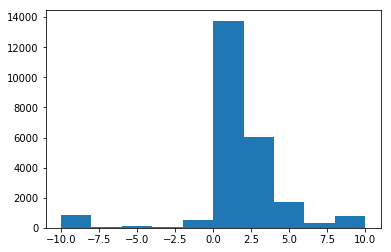

In [6]:
plt.hist(data['weight']);

# Extracting the networks

{'#nodes': 24, 'betweenness': 0.05887681159420289, 'weights max': 9.0, 'eigenvector': 0.15475284735543093, '#pos edges': 50, 'in_degree': 0.09057971014492754, 'weights std': 2.8369702148595075, 'clustering_coefficient': 621.0416666666666, '#edges': 50, 'closeness': 0.2109277411303543, 'degree': 0.18115942028985507, '#neg edges': 0, 'harmonic': 6.2467757936507935, '#gcc pos edges': 35, 'weights min': 1.0, 'load': 0.05887681159420289, 'weights mean': 3.54, 'gcc': 24, '#edges/#nodes': 2.0833333333333335, 'algebraic_connectivity': 0.167771742817808, '#gcc neg edges': 0, 'out_degree': 0.09057971014492754}


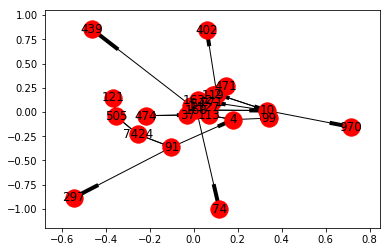



{'#nodes': 32, 'betweenness': 0.04243951612903226, 'weights max': 5.0, 'eigenvector': 0.10204038863443503, '#pos edges': 51, 'in_degree': 0.05141129032258064, 'weights std': 1.132512084564208, 'clustering_coefficient': 624.875, '#edges': 51, 'closeness': 0.11375401276721256, 'degree': 0.10282258064516128, '#neg edges': 0, 'harmonic': 4.633172123015873, '#gcc pos edges': 25, 'weights min': 1.0, 'load': 0.04243951612903226, 'weights mean': 1.8235294117647058, 'gcc': 24, '#edges/#nodes': 1.59375, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.05141129032258064}


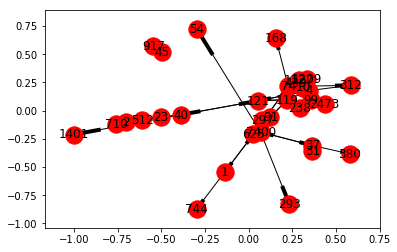



{'#nodes': 38, 'betweenness': 0.025960170697012803, 'weights max': 5.0, 'eigenvector': 0.10097630968718481, '#pos edges': 61, 'in_degree': 0.0433854907539118, 'weights std': 1.0126849319003606, 'clustering_coefficient': 690.2631578947369, '#edges': 61, 'closeness': 0.10888360520493263, 'degree': 0.08677098150782363, '#neg edges': 0, 'harmonic': 5.152516708437762, '#gcc pos edges': 34, 'weights min': 1.0, 'load': 0.025960170697012803, 'weights mean': 1.6065573770491803, 'gcc': 34, '#edges/#nodes': 1.605263157894737, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.0433854907539118}


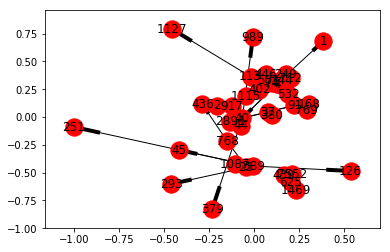



{'#nodes': 69, 'betweenness': 0.02250257663091194, 'weights max': 9.0, 'eigenvector': 0.08057902857680249, '#pos edges': 181, 'in_degree': 0.03857630008525149, 'weights std': 1.288773956439365, 'clustering_coefficient': 973.231884057971, '#edges': 181, 'closeness': 0.23488380416680177, 'degree': 0.07715260017050297, '#neg edges': 0, 'harmonic': 17.91666666666666, '#gcc pos edges': 103, 'weights min': 1.0, 'load': 0.022502576630911934, 'weights mean': 1.718232044198895, 'gcc': 66, '#edges/#nodes': 2.6231884057971016, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.03857630008525148}


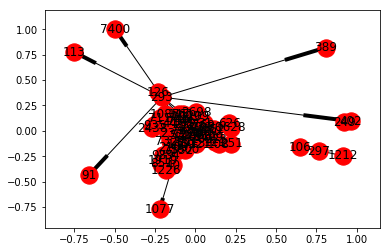



{'#nodes': 78, 'betweenness': 0.023680267101319735, 'weights max': 8.0, 'eigenvector': 0.07174357936327423, '#pos edges': 152, 'in_degree': 0.025308025308025305, 'weights std': 1.019206143738794, 'clustering_coefficient': 941.6282051282051, '#edges': 152, 'closeness': 0.17295907480693673, 'degree': 0.050616050616050616, '#neg edges': 0, 'harmonic': 15.513776963776964, '#gcc pos edges': 87, 'weights min': 1.0, 'load': 0.023680267101319732, 'weights mean': 1.5263157894736843, 'gcc': 71, '#edges/#nodes': 1.9487179487179487, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.0253080253080253}


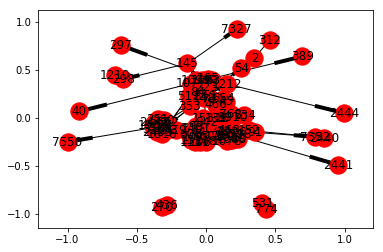



{'#nodes': 167, 'betweenness': 0.010142475181072684, 'weights max': 10.0, 'eigenvector': 0.05026291321925803, '#pos edges': 413, 'in_degree': 0.014897915013346799, 'weights std': 1.786826509621996, 'clustering_coefficient': 1063.3473053892214, '#edges': 413, 'closeness': 0.1868601511213967, 'degree': 0.029795830026693598, '#neg edges': 0, 'harmonic': 34.33421727972627, '#gcc pos edges': 242, 'weights min': 1.0, 'load': 0.010142475181072688, 'weights mean': 2.0581113801452786, 'gcc': 151, '#edges/#nodes': 2.4730538922155687, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.014897915013346802}


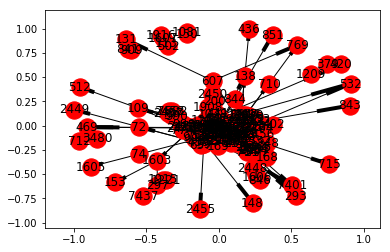



{'#nodes': 485, 'betweenness': 0.0056541478162439, 'weights max': 10.0, 'eigenvector': 0.024611337549140466, '#pos edges': 1574, 'in_degree': 0.00682031183436994, 'weights std': 2.0906819485719623, 'clustering_coefficient': 1301.7670103092782, '#edges': 1601, 'closeness': 0.20024994560404494, 'degree': 0.013640623668739882, '#neg edges': 27, 'harmonic': 105.31287923416804, '#gcc pos edges': 901, 'weights min': -10.0, 'load': 0.005654147816243901, 'weights mean': 1.7295440349781386, 'gcc': 481, '#edges/#nodes': 3.3010309278350514, 'algebraic_connectivity': 0.0, '#gcc neg edges': 22, 'out_degree': 0.006820311834369941}


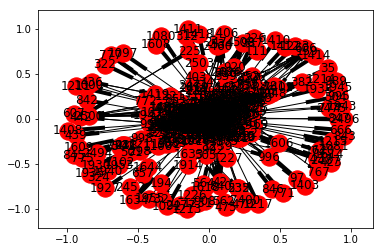



{'#nodes': 788, 'betweenness': 0.00379255103948482, 'weights max': 10.0, 'eigenvector': 0.01680985698237357, '#pos edges': 2387, 'in_degree': 0.003928043911531937, 'weights std': 2.3973489480228203, 'clustering_coefficient': 1529.8109137055837, '#edges': 2436, 'closeness': 0.17641114624033952, 'degree': 0.007856087823063873, '#neg edges': 49, 'harmonic': 150.6048589735138, '#gcc pos edges': 1358, 'weights min': -10.0, 'load': 0.00379255103948482, 'weights mean': 1.8616584564860428, 'gcc': 768, '#edges/#nodes': 3.0913705583756346, 'algebraic_connectivity': 0.0, '#gcc neg edges': 32, 'out_degree': 0.003928043911531937}


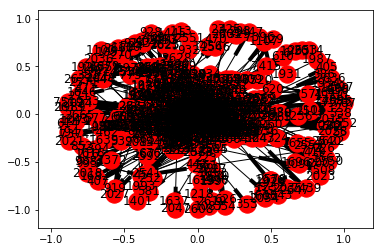



{'#nodes': 354, 'betweenness': 0.005017593530251379, 'weights max': 10.0, 'eigenvector': 0.02550061675252906, '#pos edges': 755, 'in_degree': 0.006361934027944495, 'weights std': 3.1204543063032277, 'clustering_coefficient': 1616.5593220338983, '#edges': 795, 'closeness': 0.11734867676258204, 'degree': 0.01272386805588899, '#neg edges': 40, 'harmonic': 45.83666466929184, '#gcc pos edges': 380, 'weights min': -10.0, 'load': 0.005017593530251378, 'weights mean': 1.260377358490566, 'gcc': 300, '#edges/#nodes': 2.2457627118644066, 'algebraic_connectivity': 0.0, '#gcc neg edges': 38, 'out_degree': 0.006361934027944495}


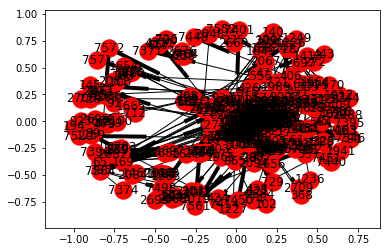



{'#nodes': 211, 'betweenness': 0.009974634993342899, 'weights max': 10.0, 'eigenvector': 0.038411793601347534, '#pos edges': 453, 'in_degree': 0.010403972015346425, 'weights std': 2.2135955312475404, 'clustering_coefficient': 1350.2796208530806, '#edges': 461, 'closeness': 0.1430942231212116, 'degree': 0.02080794403069285, '#neg edges': 8, 'harmonic': 33.70724167880567, '#gcc pos edges': 239, 'weights min': -10.0, 'load': 0.009974634993342902, 'weights mean': 1.7201735357917571, 'gcc': 177, '#edges/#nodes': 2.184834123222749, 'algebraic_connectivity': 0.0, '#gcc neg edges': 5, 'out_degree': 0.010403972015346425}


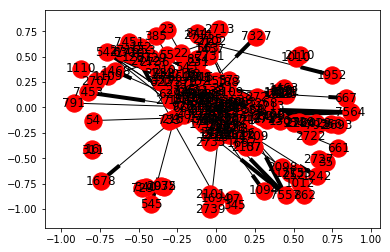



{'#nodes': 180, 'betweenness': 0.010399535496830078, 'weights max': 10.0, 'eigenvector': 0.04031465406044637, '#pos edges': 344, 'in_degree': 0.011049037864680322, 'weights std': 2.3796810492637923, 'clustering_coefficient': 1318.6944444444443, '#edges': 356, 'closeness': 0.1258408061015687, 'degree': 0.022098075729360643, '#neg edges': 12, 'harmonic': 25.508569825236485, '#gcc pos edges': 192, 'weights min': -10.0, 'load': 0.010399535496830078, 'weights mean': 1.446629213483146, 'gcc': 157, '#edges/#nodes': 1.9777777777777779, 'algebraic_connectivity': 0.0, '#gcc neg edges': 9, 'out_degree': 0.011049037864680322}


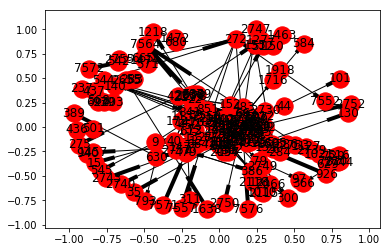



{'#nodes': 121, 'betweenness': 0.013493992638377663, 'weights max': 10.0, 'eigenvector': 0.05568910553311196, '#pos edges': 231, 'in_degree': 0.015977961432506887, 'weights std': 1.550957665106829, 'clustering_coefficient': 1128.206611570248, '#edges': 232, 'closeness': 0.13419786236227876, 'degree': 0.03195592286501378, '#neg edges': 1, 'harmonic': 18.55827758100485, '#gcc pos edges': 136, 'weights min': -1.0, 'load': 0.013493992638377666, 'weights mean': 1.706896551724138, 'gcc': 107, '#edges/#nodes': 1.9173553719008265, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.015977961432506887}


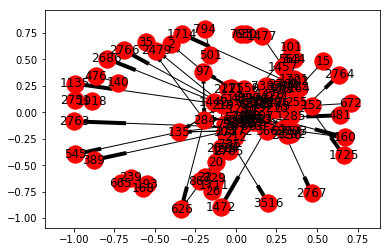



{'#nodes': 133, 'betweenness': 0.008412773780391297, 'weights max': 10.0, 'eigenvector': 0.052865655537914634, '#pos edges': 233, 'in_degree': 0.01349965823650034, 'weights std': 1.7565112486496746, 'clustering_coefficient': 1163.360902255639, '#edges': 237, 'closeness': 0.09918468659856425, 'degree': 0.02699931647300068, '#neg edges': 4, 'harmonic': 15.198576799140701, '#gcc pos edges': 141, 'weights min': -10.0, 'load': 0.008412773780391295, 'weights mean': 1.489451476793249, 'gcc': 112, '#edges/#nodes': 1.781954887218045, 'algebraic_connectivity': 0.0, '#gcc neg edges': 4, 'out_degree': 0.01349965823650034}


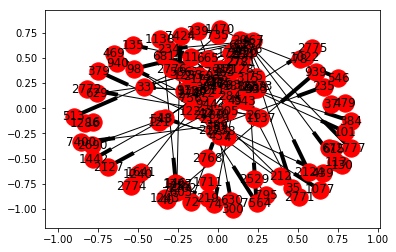



{'#nodes': 142, 'betweenness': 0.01317764744495341, 'weights max': 10.0, 'eigenvector': 0.054716287811029975, '#pos edges': 301, 'in_degree': 0.015233243432224552, 'weights std': 1.8339390495642969, 'clustering_coefficient': 1382.105633802817, '#edges': 305, 'closeness': 0.14958799146543045, 'degree': 0.030466486864449104, '#neg edges': 4, 'harmonic': 24.011183769282347, '#gcc pos edges': 182, 'weights min': -10.0, 'load': 0.013177647444953406, 'weights mean': 1.5377049180327869, 'gcc': 129, '#edges/#nodes': 2.147887323943662, 'algebraic_connectivity': 0.0, '#gcc neg edges': 3, 'out_degree': 0.015233243432224552}


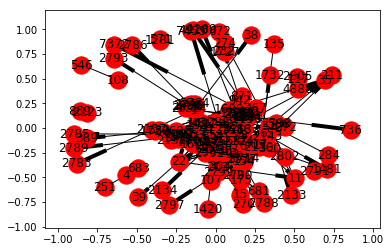



{'#nodes': 160, 'betweenness': 0.010408456731151977, 'weights max': 10.0, 'eigenvector': 0.04837895503839332, '#pos edges': 378, 'in_degree': 0.014976415094339623, 'weights std': 1.8527023441781096, 'clustering_coefficient': 1193.1125, '#edges': 381, 'closeness': 0.18176734828283148, 'degree': 0.029952830188679246, '#neg edges': 3, 'harmonic': 32.22984375, '#gcc pos edges': 222, 'weights min': -1.0, 'load': 0.010408456731151977, 'weights mean': 1.9081364829396326, 'gcc': 145, '#edges/#nodes': 2.38125, 'algebraic_connectivity': 0.0, '#gcc neg edges': 2, 'out_degree': 0.014976415094339623}


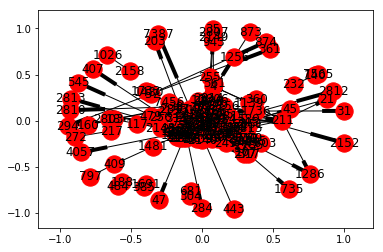



{'#nodes': 171, 'betweenness': 0.01258846733959856, 'weights max': 10.0, 'eigenvector': 0.048289032651702216, '#pos edges': 342, 'in_degree': 0.01214310285517716, 'weights std': 2.1899574465720715, 'clustering_coefficient': 1305.0526315789473, '#edges': 353, 'closeness': 0.1307888681848851, 'degree': 0.024286205710354315, '#neg edges': 11, 'harmonic': 25.437988489742875, '#gcc pos edges': 215, 'weights min': -10.0, 'load': 0.01258846733959856, 'weights mean': 1.6940509915014164, 'gcc': 162, '#edges/#nodes': 2.064327485380117, 'algebraic_connectivity': 0.0, '#gcc neg edges': 10, 'out_degree': 0.01214310285517716}


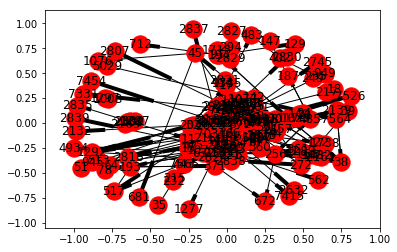



{'#nodes': 192, 'betweenness': 0.009734086525213556, 'weights max': 10.0, 'eigenvector': 0.044147446662168355, '#pos edges': 448, 'in_degree': 0.012679973821989531, 'weights std': 2.2260651244423997, 'clustering_coefficient': 1193.03125, '#edges': 465, 'closeness': 0.15678209319613792, 'degree': 0.02535994764397906, '#neg edges': 17, 'harmonic': 33.44735036375662, '#gcc pos edges': 281, 'weights min': -10.0, 'load': 0.009734086525213556, 'weights mean': 1.4967741935483871, 'gcc': 180, '#edges/#nodes': 2.421875, 'algebraic_connectivity': 0.0, '#gcc neg edges': 14, 'out_degree': 0.01267997382198953}


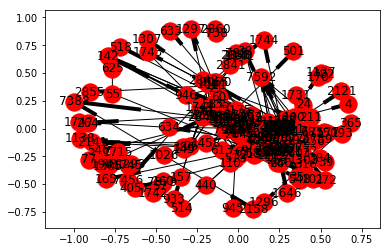



{'#nodes': 222, 'betweenness': 0.00872754696284108, 'weights max': 10.0, 'eigenvector': 0.03990470670118592, '#pos edges': 492, 'in_degree': 0.010313480901716196, 'weights std': 2.2134740256926944, 'clustering_coefficient': 1298.9864864864865, '#edges': 506, 'closeness': 0.1378429461863625, 'degree': 0.02062696180343239, '#neg edges': 14, 'harmonic': 34.33304213304215, '#gcc pos edges': 288, 'weights min': -10.0, 'load': 0.00872754696284108, 'weights mean': 1.6956521739130435, 'gcc': 195, '#edges/#nodes': 2.279279279279279, 'algebraic_connectivity': 0.0, '#gcc neg edges': 12, 'out_degree': 0.010313480901716196}


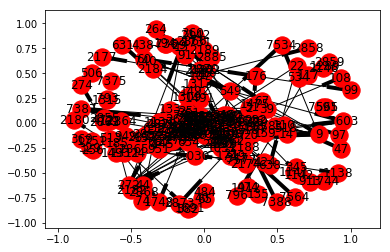



{'#nodes': 213, 'betweenness': 0.012349919961510997, 'weights max': 10.0, 'eigenvector': 0.0399437603987929, '#pos edges': 477, 'in_degree': 0.01113916201612189, 'weights std': 2.4194773838413477, 'clustering_coefficient': 1313.1924882629107, '#edges': 503, 'closeness': 0.17294506062522275, 'degree': 0.02227832403224378, '#neg edges': 26, 'harmonic': 41.1747808399217, '#gcc pos edges': 298, 'weights min': -10.0, 'load': 0.012349919961510997, 'weights mean': 1.2067594433399602, 'gcc': 211, '#edges/#nodes': 2.3615023474178405, 'algebraic_connectivity': 0.0, '#gcc neg edges': 22, 'out_degree': 0.01113916201612189}


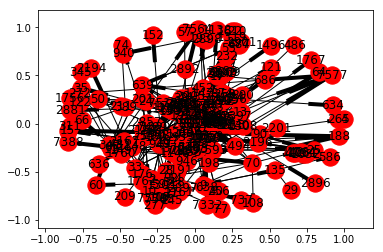



{'#nodes': 241, 'betweenness': 0.0105729555489968, 'weights max': 10.0, 'eigenvector': 0.03652092074729694, '#pos edges': 489, 'in_degree': 0.008730982019363764, 'weights std': 2.3121675994487076, 'clustering_coefficient': 1217.8008298755187, '#edges': 505, 'closeness': 0.12938770870565713, 'degree': 0.017461964038727528, '#neg edges': 16, 'harmonic': 35.42900642464959, '#gcc pos edges': 294, 'weights min': -10.0, 'load': 0.0105729555489968, 'weights mean': 1.889108910891089, 'gcc': 229, '#edges/#nodes': 2.095435684647303, 'algebraic_connectivity': 0.0, '#gcc neg edges': 16, 'out_degree': 0.008730982019363764}


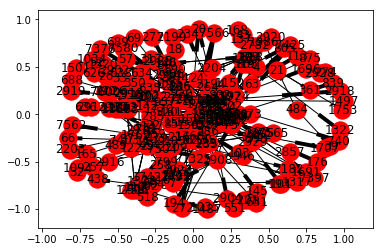



{'#nodes': 286, 'betweenness': 0.0075501407413935216, 'weights max': 10.0, 'eigenvector': 0.03245778629219389, '#pos edges': 649, 'in_degree': 0.008195313458471352, 'weights std': 2.063925581415737, 'clustering_coefficient': 1182.1993006993007, '#edges': 668, 'closeness': 0.12006342929327574, 'degree': 0.016390626916942708, '#neg edges': 19, 'harmonic': 38.587573857766195, '#gcc pos edges': 396, 'weights min': -10.0, 'load': 0.00755014074139352, 'weights mean': 1.6616766467065869, 'gcc': 258, '#edges/#nodes': 2.335664335664336, 'algebraic_connectivity': 0.0, '#gcc neg edges': 17, 'out_degree': 0.008195313458471354}


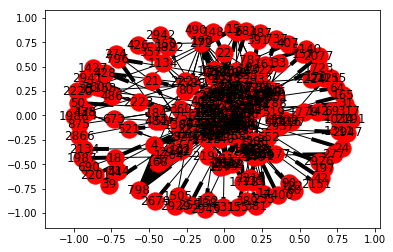



{'#nodes': 265, 'betweenness': 0.007779078539176108, 'weights max': 10.0, 'eigenvector': 0.033505999651796, '#pos edges': 578, 'in_degree': 0.008533447684391078, 'weights std': 2.1971097191057236, 'clustering_coefficient': 1274.0264150943397, '#edges': 597, 'closeness': 0.1361293255891951, 'degree': 0.017066895368782156, '#neg edges': 19, 'harmonic': 39.79165169212342, '#gcc pos edges': 348, 'weights min': -10.0, 'load': 0.007779078539176107, 'weights mean': 1.6800670016750419, 'gcc': 238, '#edges/#nodes': 2.2528301886792454, 'algebraic_connectivity': 0.0, '#gcc neg edges': 15, 'out_degree': 0.008533447684391078}


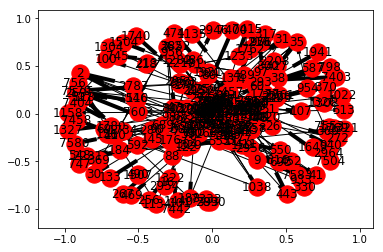



{'#nodes': 259, 'betweenness': 0.007326509000565646, 'weights max': 10.0, 'eigenvector': 0.03473175571769587, '#pos edges': 582, 'in_degree': 0.008829427434078599, 'weights std': 2.0746593536038924, 'clustering_coefficient': 923.7915057915058, '#edges': 590, 'closeness': 0.11366955126536211, 'degree': 0.017658854868157197, '#neg edges': 8, 'harmonic': 33.17063297063299, '#gcc pos edges': 344, 'weights min': -10.0, 'load': 0.007326509000565646, 'weights mean': 1.8949152542372882, 'gcc': 230, '#edges/#nodes': 2.277992277992278, 'algebraic_connectivity': 0.0, '#gcc neg edges': 7, 'out_degree': 0.008829427434078599}


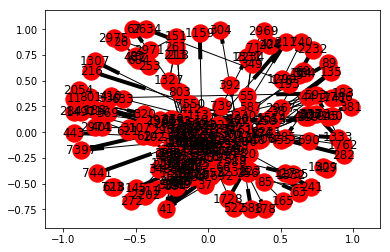



{'#nodes': 279, 'betweenness': 0.006469216149148923, 'weights max': 10.0, 'eigenvector': 0.030986173201328765, '#pos edges': 558, 'in_degree': 0.007671282328975528, 'weights std': 2.7970850484075127, 'clustering_coefficient': 1174.7240143369177, '#edges': 595, 'closeness': 0.10010520610384292, 'degree': 0.01534256465795106, '#neg edges': 37, 'harmonic': 31.556926406926422, '#gcc pos edges': 345, 'weights min': -10.0, 'load': 0.006469216149148924, 'weights mean': 1.3865546218487395, 'gcc': 259, '#edges/#nodes': 2.132616487455197, 'algebraic_connectivity': 0.0, '#gcc neg edges': 37, 'out_degree': 0.00767128232897553}


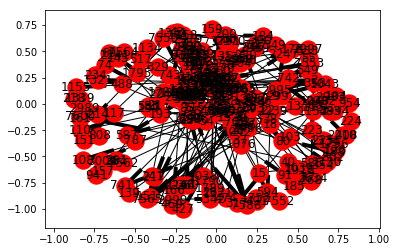



{'#nodes': 292, 'betweenness': 0.004893985361506509, 'weights max': 10.0, 'eigenvector': 0.025751463082576073, '#pos edges': 555, 'in_degree': 0.007578967189191734, 'weights std': 4.381599086537737, 'clustering_coefficient': 1466.1678082191781, '#edges': 644, 'closeness': 0.09554638254599482, 'degree': 0.015157934378383465, '#neg edges': 89, 'harmonic': 31.454458849749955, '#gcc pos edges': 372, 'weights min': -10.0, 'load': 0.004893985361506509, 'weights mean': 0.9813664596273292, 'gcc': 271, '#edges/#nodes': 2.2054794520547945, 'algebraic_connectivity': 0.0, '#gcc neg edges': 75, 'out_degree': 0.007578967189191734}


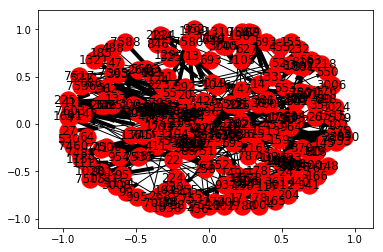



{'#nodes': 288, 'betweenness': 0.00611427021487997, 'weights max': 10.0, 'eigenvector': 0.032942965851975745, '#pos edges': 488, 'in_degree': 0.006557297715834301, 'weights std': 3.232807717355711, 'clustering_coefficient': 1327.7777777777778, '#edges': 542, 'closeness': 0.09315573174359917, 'degree': 0.013114595431668603, '#neg edges': 54, 'harmonic': 30.691306667869178, '#gcc pos edges': 286, 'weights min': -10.0, 'load': 0.00611427021487997, 'weights mean': 0.9686346863468634, 'gcc': 251, '#edges/#nodes': 1.8819444444444444, 'algebraic_connectivity': 0.0, '#gcc neg edges': 45, 'out_degree': 0.006557297715834302}


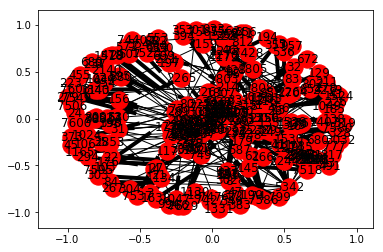



{'#nodes': 313, 'betweenness': 0.005016032390882149, 'weights max': 10.0, 'eigenvector': 0.031760812593014075, '#pos edges': 590, 'in_degree': 0.006502416646186614, 'weights std': 2.7126248241632815, 'clustering_coefficient': 1568.0479233226838, '#edges': 635, 'closeness': 0.10835731290884525, 'degree': 0.013004833292373228, '#neg edges': 45, 'harmonic': 37.91652098345393, '#gcc pos edges': 366, 'weights min': -10.0, 'load': 0.005016032390882149, 'weights mean': 1.2818897637795275, 'gcc': 278, '#edges/#nodes': 2.0287539936102235, 'algebraic_connectivity': 0.0, '#gcc neg edges': 36, 'out_degree': 0.006502416646186615}


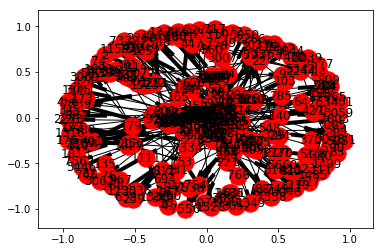



{'#nodes': 305, 'betweenness': 0.006258453714223882, 'weights max': 10.0, 'eigenvector': 0.02845849467869083, '#pos edges': 599, 'in_degree': 0.006719154443485763, 'weights std': 2.7403613954351846, 'clustering_coefficient': 1425.4229508196722, '#edges': 623, 'closeness': 0.11153315339344852, 'degree': 0.013438308886971525, '#neg edges': 24, 'harmonic': 38.51720199654629, '#gcc pos edges': 365, 'weights min': -10.0, 'load': 0.006258453714223882, 'weights mean': 1.7014446227929374, 'gcc': 278, '#edges/#nodes': 2.042622950819672, 'algebraic_connectivity': 0.0, '#gcc neg edges': 20, 'out_degree': 0.006719154443485763}


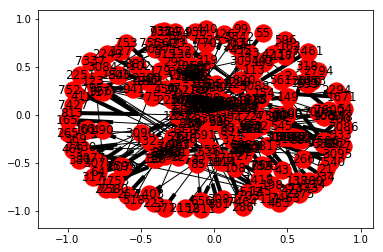



{'#nodes': 256, 'betweenness': 0.009105295661571715, 'weights max': 10.0, 'eigenvector': 0.030937418374744053, '#pos edges': 465, 'in_degree': 0.007950367647058823, 'weights std': 3.753237347887891, 'clustering_coefficient': 1491.02734375, '#edges': 519, 'closeness': 0.09682875152872139, 'degree': 0.015900735294117646, '#neg edges': 54, 'harmonic': 30.522133800890707, '#gcc pos edges': 283, 'weights min': -10.0, 'load': 0.009105295661571715, 'weights mean': 1.157996146435453, 'gcc': 229, '#edges/#nodes': 2.02734375, 'algebraic_connectivity': 0.0, '#gcc neg edges': 44, 'out_degree': 0.007950367647058823}


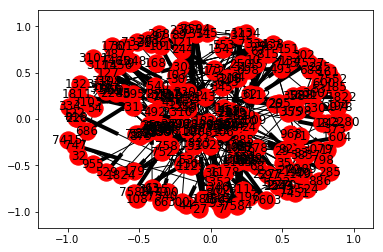



{'#nodes': 254, 'betweenness': 0.007752736441541646, 'weights max': 10.0, 'eigenvector': 0.030251383899312236, '#pos edges': 450, 'in_degree': 0.007391615573744982, 'weights std': 2.8381227457989913, 'clustering_coefficient': 1286.0708661417323, '#edges': 475, 'closeness': 0.09686346627862741, 'degree': 0.014783231147489962, '#neg edges': 25, 'harmonic': 28.480982086592334, '#gcc pos edges': 276, 'weights min': -10.0, 'load': 0.007752736441541645, 'weights mean': 1.5747368421052632, 'gcc': 230, '#edges/#nodes': 1.8700787401574803, 'algebraic_connectivity': 0.0, '#gcc neg edges': 20, 'out_degree': 0.007391615573744981}


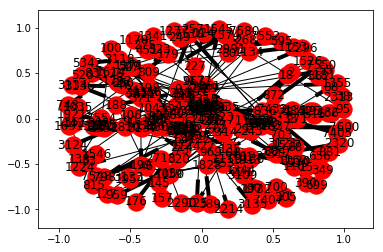



{'#nodes': 315, 'betweenness': 0.005298003832832182, 'weights max': 10.0, 'eigenvector': 0.02612040749131229, '#pos edges': 592, 'in_degree': 0.006217773733697301, 'weights std': 2.4589247768552283, 'clustering_coefficient': 1227.6380952380953, '#edges': 615, 'closeness': 0.10348194594954215, 'degree': 0.0124355474673946, '#neg edges': 23, 'harmonic': 36.893710795377494, '#gcc pos edges': 338, 'weights min': -10.0, 'load': 0.005298003832832184, 'weights mean': 1.7772357723577237, 'gcc': 268, '#edges/#nodes': 1.9523809523809523, 'algebraic_connectivity': 0.0, '#gcc neg edges': 19, 'out_degree': 0.006217773733697301}


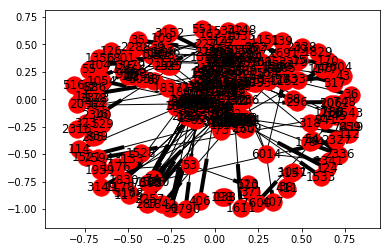



{'#nodes': 421, 'betweenness': 0.004187921916197019, 'weights max': 10.0, 'eigenvector': 0.019992705837826672, '#pos edges': 758, 'in_degree': 0.005095577423368397, 'weights std': 4.940089907287258, 'clustering_coefficient': 1408.2755344418051, '#edges': 901, 'closeness': 0.10139782678636931, 'degree': 0.010191154846736794, '#neg edges': 143, 'harmonic': 47.687670952694766, '#gcc pos edges': 437, 'weights min': -10.0, 'load': 0.00418792191619702, 'weights mean': 0.6659267480577137, 'gcc': 362, '#edges/#nodes': 2.1401425178147266, 'algebraic_connectivity': 0.0, '#gcc neg edges': 139, 'out_degree': 0.005095577423368398}


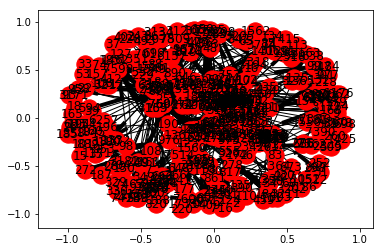



{'#nodes': 301, 'betweenness': 0.007271377089375067, 'weights max': 10.0, 'eigenvector': 0.027269084084910796, '#pos edges': 531, 'in_degree': 0.0064341085271317836, 'weights std': 3.462477249056652, 'clustering_coefficient': 1487.0498338870432, '#edges': 581, 'closeness': 0.09284824336647539, 'degree': 0.012868217054263567, '#neg edges': 50, 'harmonic': 32.20055601467564, '#gcc pos edges': 307, 'weights min': -10.0, 'load': 0.007271377089375067, 'weights mean': 1.225473321858864, 'gcc': 265, '#edges/#nodes': 1.930232558139535, 'algebraic_connectivity': 0.0, '#gcc neg edges': 42, 'out_degree': 0.0064341085271317836}


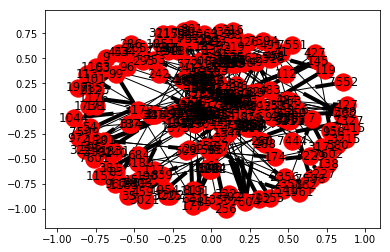



{'#nodes': 237, 'betweenness': 0.006117230497214703, 'weights max': 10.0, 'eigenvector': 0.02873031950210642, '#pos edges': 409, 'in_degree': 0.007759422155474505, 'weights std': 3.1123292679175383, 'clustering_coefficient': 1319.5991561181434, '#edges': 434, 'closeness': 0.08189377362403237, 'degree': 0.01551884431094901, '#neg edges': 25, 'harmonic': 22.31129422616764, '#gcc pos edges': 242, 'weights min': -10.0, 'load': 0.006117230497214703, 'weights mean': 1.5345622119815667, 'gcc': 211, '#edges/#nodes': 1.8312236286919832, 'algebraic_connectivity': 0.0, '#gcc neg edges': 24, 'out_degree': 0.007759422155474504}


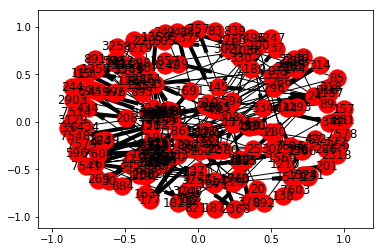



{'#nodes': 212, 'betweenness': 0.007282205558607239, 'weights max': 10.0, 'eigenvector': 0.03372221678321553, '#pos edges': 378, 'in_degree': 0.00885272288294733, 'weights std': 2.6105493407370037, 'clustering_coefficient': 1186.938679245283, '#edges': 396, 'closeness': 0.10305533585555686, 'degree': 0.01770544576589466, '#neg edges': 18, 'harmonic': 24.589345952789348, '#gcc pos edges': 206, 'weights min': -10.0, 'load': 0.007282205558607239, 'weights mean': 1.5757575757575757, 'gcc': 170, '#edges/#nodes': 1.8679245283018868, 'algebraic_connectivity': 0.0, '#gcc neg edges': 13, 'out_degree': 0.00885272288294733}


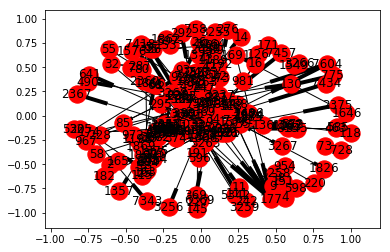



{'#nodes': 215, 'betweenness': 0.009314978474775335, 'weights max': 10.0, 'eigenvector': 0.034327901731522587, '#pos edges': 417, 'in_degree': 0.010106498587263637, 'weights std': 3.9310827967799558, 'clustering_coefficient': 1311.553488372093, '#edges': 465, 'closeness': 0.11579011399597397, 'degree': 0.020212997174527278, '#neg edges': 48, 'harmonic': 28.810753380985947, '#gcc pos edges': 243, 'weights min': -10.0, 'load': 0.009314978474775335, 'weights mean': 0.7720430107526882, 'gcc': 189, '#edges/#nodes': 2.1627906976744184, 'algebraic_connectivity': 0.0, '#gcc neg edges': 38, 'out_degree': 0.010106498587263637}


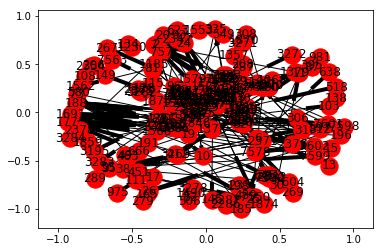



{'#nodes': 210, 'betweenness': 0.007825726904674273, 'weights max': 10.0, 'eigenvector': 0.033287609217009274, '#pos edges': 345, 'in_degree': 0.008407382091592617, 'weights std': 3.2559935226926124, 'clustering_coefficient': 1346.9, '#edges': 369, 'closeness': 0.08947908957534229, 'degree': 0.016814764183185237, '#neg edges': 24, 'harmonic': 21.796426509997932, '#gcc pos edges': 217, 'weights min': -10.0, 'load': 0.007825726904674273, 'weights mean': 1.5284552845528456, 'gcc': 181, '#edges/#nodes': 1.7571428571428571, 'algebraic_connectivity': 0.0, '#gcc neg edges': 22, 'out_degree': 0.008407382091592619}


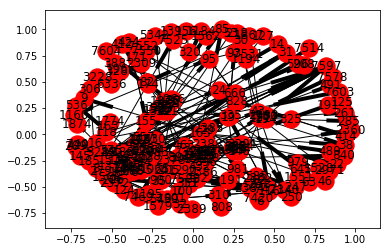



{'#nodes': 186, 'betweenness': 0.006900483934144523, 'weights max': 10.0, 'eigenvector': 0.03187435725880895, '#pos edges': 289, 'in_degree': 0.00871839581517001, 'weights std': 2.4005184625178138, 'clustering_coefficient': 973.5322580645161, '#edges': 300, 'closeness': 0.057060954485224503, 'degree': 0.01743679163034002, '#neg edges': 11, 'harmonic': 12.683689428850714, '#gcc pos edges': 171, 'weights min': -10.0, 'load': 0.006900483934144524, 'weights mean': 1.5866666666666667, 'gcc': 151, '#edges/#nodes': 1.6129032258064515, 'algebraic_connectivity': 0.0, '#gcc neg edges': 5, 'out_degree': 0.00871839581517001}


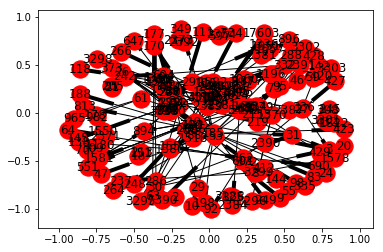



{'#nodes': 150, 'betweenness': 0.008718181268516841, 'weights max': 10.0, 'eigenvector': 0.040263177117735034, '#pos edges': 259, 'in_degree': 0.011946308724832214, 'weights std': 2.1413659111240757, 'clustering_coefficient': 1051.66, '#edges': 267, 'closeness': 0.09736309422698824, 'degree': 0.02389261744966443, '#neg edges': 8, 'harmonic': 16.944406445406432, '#gcc pos edges': 137, 'weights min': -10.0, 'load': 0.00871818126851684, 'weights mean': 1.595505617977528, 'gcc': 114, '#edges/#nodes': 1.78, 'algebraic_connectivity': 0.0, '#gcc neg edges': 5, 'out_degree': 0.011946308724832214}


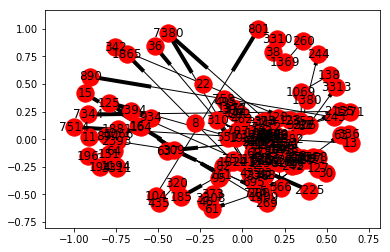



{'#nodes': 246, 'betweenness': 0.005302980848476935, 'weights max': 10.0, 'eigenvector': 0.032663757547936045, '#pos edges': 437, 'in_degree': 0.00819644931143189, 'weights std': 3.4593074705557627, 'clustering_coefficient': 1754.3089430894308, '#edges': 494, 'closeness': 0.08716199240689698, 'degree': 0.01639289862286378, '#neg edges': 57, 'harmonic': 24.216992515163245, '#gcc pos edges': 256, 'weights min': -10.0, 'load': 0.005302980848476936, 'weights mean': 0.97165991902834, 'gcc': 214, '#edges/#nodes': 2.008130081300813, 'algebraic_connectivity': 0.0, '#gcc neg edges': 54, 'out_degree': 0.00819644931143189}


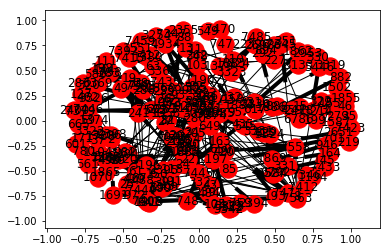



{'#nodes': 194, 'betweenness': 0.0043148681071167845, 'weights max': 10.0, 'eigenvector': 0.03130286109092282, '#pos edges': 234, 'in_degree': 0.007958976550397949, 'weights std': 4.006083219447255, 'clustering_coefficient': 1317.659793814433, '#edges': 298, 'closeness': 0.049185837448963224, 'degree': 0.015917953100795898, '#neg edges': 64, 'harmonic': 11.120580808080803, '#gcc pos edges': 139, 'weights min': -10.0, 'load': 0.0043148681071167845, 'weights mean': 0.7953020134228188, 'gcc': 159, '#edges/#nodes': 1.5360824742268042, 'algebraic_connectivity': 0.0, '#gcc neg edges': 61, 'out_degree': 0.007958976550397949}


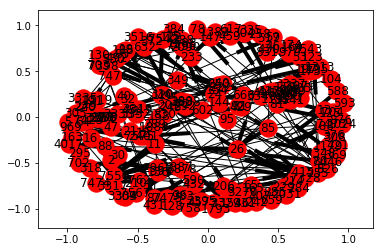



{'#nodes': 158, 'betweenness': 0.005935030193274167, 'weights max': 10.0, 'eigenvector': 0.03203252042664142, '#pos edges': 209, 'in_degree': 0.009191324679513021, 'weights std': 2.3590906206585025, 'clustering_coefficient': 1088.607594936709, '#edges': 228, 'closeness': 0.043594206631159614, 'degree': 0.018382649359026042, '#neg edges': 19, 'harmonic': 8.676347913689684, '#gcc pos edges': 106, 'weights min': -10.0, 'load': 0.005935030193274166, 'weights mean': 1.6885964912280702, 'gcc': 112, '#edges/#nodes': 1.4430379746835442, 'algebraic_connectivity': 0.0, '#gcc neg edges': 17, 'out_degree': 0.009191324679513021}


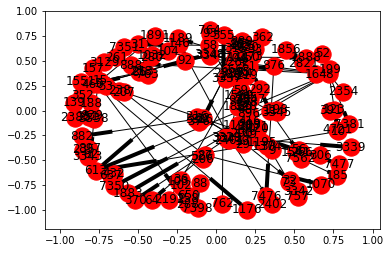



{'#nodes': 179, 'betweenness': 0.0050980801032134695, 'weights max': 10.0, 'eigenvector': 0.02452653305929083, '#pos edges': 232, 'in_degree': 0.008787897809302617, 'weights std': 3.685852710578874, 'clustering_coefficient': 1777.2402234636872, '#edges': 280, 'closeness': 0.0481911762938754, 'degree': 0.017575795618605235, '#neg edges': 48, 'harmonic': 10.257937717155588, '#gcc pos edges': 122, 'weights min': -10.0, 'load': 0.0050980801032134695, 'weights mean': 0.9857142857142858, 'gcc': 138, '#edges/#nodes': 1.5642458100558658, 'algebraic_connectivity': 0.0, '#gcc neg edges': 44, 'out_degree': 0.008787897809302617}


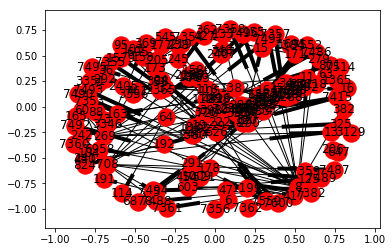



{'#nodes': 141, 'betweenness': 0.002804807825472145, 'weights max': 10.0, 'eigenvector': 0.04149774459479625, '#pos edges': 145, 'in_degree': 0.010030395136778114, 'weights std': 4.532911988197613, 'clustering_coefficient': 1256.0567375886526, '#edges': 198, 'closeness': 0.0472485230062886, 'degree': 0.020060790273556228, '#neg edges': 53, 'harmonic': 7.638095238095238, '#gcc pos edges': 81, 'weights min': -10.0, 'load': 0.002804807825472145, 'weights mean': 0.5757575757575758, 'gcc': 107, '#edges/#nodes': 1.4042553191489362, 'algebraic_connectivity': 0.0, '#gcc neg edges': 44, 'out_degree': 0.010030395136778114}


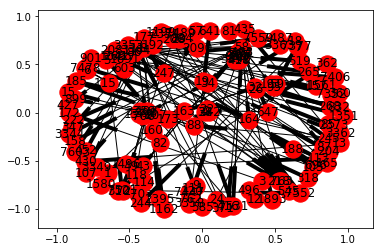



{'#nodes': 151, 'betweenness': 0.010077781234721545, 'weights max': 10.0, 'eigenvector': 0.03877805413263783, '#pos edges': 207, 'in_degree': 0.01055187637969095, 'weights std': 2.7365872008556145, 'clustering_coefficient': 1167.7549668874171, '#edges': 239, 'closeness': 0.05381389551254068, 'degree': 0.021103752759381898, '#neg edges': 32, 'harmonic': 10.739787364952923, '#gcc pos edges': 139, 'weights min': -10.0, 'load': 0.010077781234721545, 'weights mean': 1.0251046025104602, 'gcc': 126, '#edges/#nodes': 1.5827814569536425, 'algebraic_connectivity': 0.0, '#gcc neg edges': 28, 'out_degree': 0.01055187637969095}


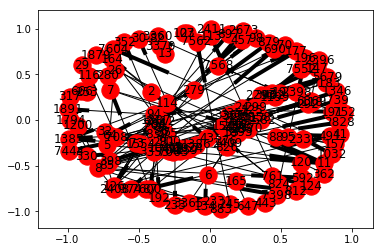



{'#nodes': 145, 'betweenness': 0.004181402888299441, 'weights max': 10.0, 'eigenvector': 0.027819750280130312, '#pos edges': 235, 'in_degree': 0.013266283524904214, 'weights std': 3.232545081550734, 'clustering_coefficient': 1214.4344827586208, '#edges': 277, 'closeness': 0.05115266320441922, 'degree': 0.026532567049808428, '#neg edges': 42, 'harmonic': 9.090555555555554, '#gcc pos edges': 165, 'weights min': -10.0, 'load': 0.004181402888299441, 'weights mean': 1.2851985559566788, 'gcc': 129, '#edges/#nodes': 1.910344827586207, 'algebraic_connectivity': 0.0, '#gcc neg edges': 36, 'out_degree': 0.013266283524904214}


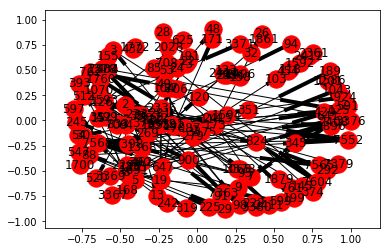



{'#nodes': 136, 'betweenness': 0.010358339023835074, 'weights max': 10.0, 'eigenvector': 0.05258765894500085, '#pos edges': 196, 'in_degree': 0.011982570806100218, 'weights std': 2.7629335230679293, 'clustering_coefficient': 952.1029411764706, '#edges': 220, 'closeness': 0.073644090273241, 'degree': 0.023965141612200435, '#neg edges': 24, 'harmonic': 12.088461824123584, '#gcc pos edges': 133, 'weights min': -10.0, 'load': 0.010358339023835072, 'weights mean': 1.6272727272727272, 'gcc': 129, '#edges/#nodes': 1.6176470588235294, 'algebraic_connectivity': 0.0, '#gcc neg edges': 23, 'out_degree': 0.01198257080610022}


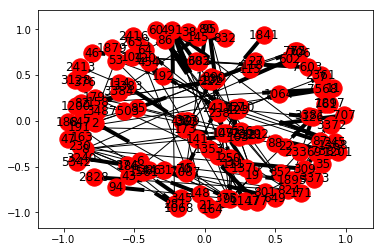



{'#nodes': 143, 'betweenness': 0.006775763443429011, 'weights max': 10.0, 'eigenvector': 0.04588960668597127, '#pos edges': 201, 'in_degree': 0.01088348271446863, 'weights std': 2.9376309991321405, 'clustering_coefficient': 1062.6993006993007, '#edges': 221, 'closeness': 0.05568220725078585, 'degree': 0.02176696542893726, '#neg edges': 20, 'harmonic': 9.732714080791, '#gcc pos edges': 132, 'weights min': -10.0, 'load': 0.006775763443429011, 'weights mean': 1.4027149321266967, 'gcc': 110, '#edges/#nodes': 1.5454545454545454, 'algebraic_connectivity': 0.0, '#gcc neg edges': 14, 'out_degree': 0.01088348271446863}


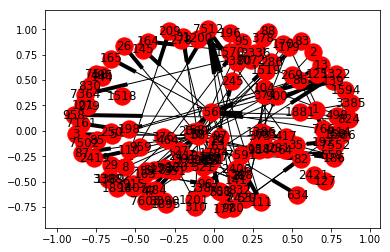



{'#nodes': 130, 'betweenness': 0.0056131671138938575, 'weights max': 10.0, 'eigenvector': 0.04020278323841379, '#pos edges': 169, 'in_degree': 0.01210494931425164, 'weights std': 3.189753122485619, 'clustering_coefficient': 1125.1846153846154, '#edges': 203, 'closeness': 0.0562876335603632, 'degree': 0.02420989862850328, '#neg edges': 34, 'harmonic': 8.659551559551556, '#gcc pos edges': 116, 'weights min': -10.0, 'load': 0.0056131671138938575, 'weights mean': 0.7142857142857143, 'gcc': 109, '#edges/#nodes': 1.5615384615384615, 'algebraic_connectivity': 0.0, '#gcc neg edges': 30, 'out_degree': 0.012104949314251639}


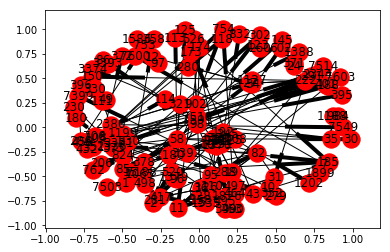



{'#nodes': 169, 'betweenness': 0.007323054651474735, 'weights max': 10.0, 'eigenvector': 0.03706925194210518, '#pos edges': 211, 'in_degree': 0.010073260073260072, 'weights std': 4.742275867135901, 'clustering_coefficient': 1567.0355029585799, '#edges': 286, 'closeness': 0.060240287110482765, 'degree': 0.020146520146520144, '#neg edges': 75, 'harmonic': 12.564425351111737, '#gcc pos edges': 130, 'weights min': -10.0, 'load': 0.007323054651474735, 'weights mean': 0.17832167832167833, 'gcc': 143, '#edges/#nodes': 1.6923076923076923, 'algebraic_connectivity': 0.0, '#gcc neg edges': 68, 'out_degree': 0.010073260073260072}


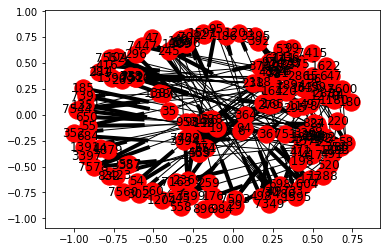



{'#nodes': 106, 'betweenness': 0.010040431266846358, 'weights max': 10.0, 'eigenvector': 0.04446021889851276, '#pos edges': 134, 'in_degree': 0.01320754716981132, 'weights std': 2.702110692316374, 'clustering_coefficient': 1164.1415094339623, '#edges': 147, 'closeness': 0.04436535364305748, 'degree': 0.02641509433962264, '#neg edges': 13, 'harmonic': 6.107821921265317, '#gcc pos edges': 60, 'weights min': -10.0, 'load': 0.010040431266846358, 'weights mean': 1.653061224489796, 'gcc': 62, '#edges/#nodes': 1.3867924528301887, 'algebraic_connectivity': 0.0, '#gcc neg edges': 7, 'out_degree': 0.01320754716981132}


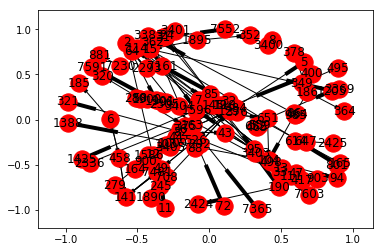



{'#nodes': 104, 'betweenness': 0.003136486110500959, 'weights max': 10.0, 'eigenvector': 0.037949815521906044, '#pos edges': 146, 'in_degree': 0.015029873039581775, 'weights std': 2.7997200144395, 'clustering_coefficient': 1030.451923076923, '#edges': 161, 'closeness': 0.03811653696480439, 'degree': 0.03005974607916355, '#neg edges': 15, 'harmonic': 4.895101079476079, '#gcc pos edges': 95, 'weights min': -10.0, 'load': 0.003136486110500959, 'weights mean': 1.8881987577639752, 'gcc': 74, '#edges/#nodes': 1.5480769230769231, 'algebraic_connectivity': 0.0, '#gcc neg edges': 10, 'out_degree': 0.015029873039581775}


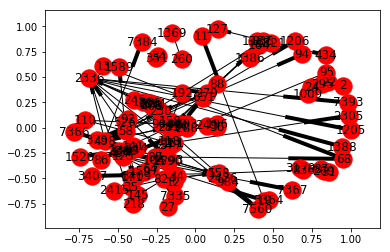



{'#nodes': 100, 'betweenness': 0.005418470418470418, 'weights max': 9.0, 'eigenvector': 0.04588738093522733, '#pos edges': 134, 'in_degree': 0.014747474747474749, 'weights std': 2.1640800897010823, 'clustering_coefficient': 997.18, '#edges': 146, 'closeness': 0.040102237286969815, 'degree': 0.029494949494949498, '#neg edges': 12, 'harmonic': 5.111529581529582, '#gcc pos edges': 92, 'weights min': -10.0, 'load': 0.005418470418470418, 'weights mean': 1.9589041095890412, 'gcc': 87, '#edges/#nodes': 1.46, 'algebraic_connectivity': 0.0, '#gcc neg edges': 12, 'out_degree': 0.014747474747474749}


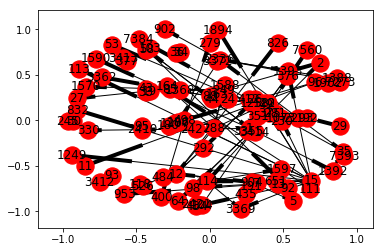



{'#nodes': 86, 'betweenness': 0.013179923132043515, 'weights max': 10.0, 'eigenvector': 0.05578354748826194, '#pos edges': 96, 'in_degree': 0.016963064295485636, 'weights std': 2.9576441112591225, 'clustering_coefficient': 920.6046511627907, '#edges': 124, 'closeness': 0.05916070498231207, 'degree': 0.03392612859097127, '#neg edges': 28, 'harmonic': 6.745952884324981, '#gcc pos edges': 61, 'weights min': -10.0, 'load': 0.013179923132043515, 'weights mean': 0.45161290322580644, 'gcc': 73, '#edges/#nodes': 1.441860465116279, 'algebraic_connectivity': 0.0, '#gcc neg edges': 22, 'out_degree': 0.016963064295485632}


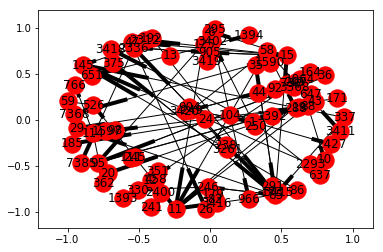



{'#nodes': 55, 'betweenness': 0.00017787942316244203, 'weights max': 8.0, 'eigenvector': 0.05620631670708973, '#pos edges': 44, 'in_degree': 0.01818181818181818, 'weights std': 3.8200252083713524, 'clustering_coefficient': 1239.1090909090908, '#edges': 54, 'closeness': 0.021121970061364, 'degree': 0.03636363636363636, '#neg edges': 10, 'harmonic': 1.212121212121212, '#gcc pos edges': 12, 'weights min': -10.0, 'load': 0.00017787942316244203, 'weights mean': 1.3333333333333333, 'gcc': 19, '#edges/#nodes': 0.9818181818181818, 'algebraic_connectivity': 0.0, '#gcc neg edges': 8, 'out_degree': 0.018181818181818177}


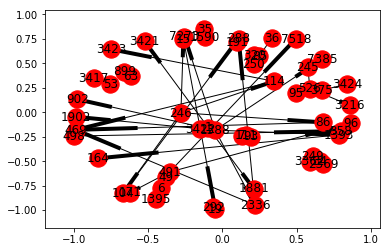



{'#nodes': 29, 'betweenness': 0.0013227513227513227, 'weights max': 3.0, 'eigenvector': 0.04876724457358791, '#pos edges': 24, 'in_degree': 0.03448275862068965, 'weights std': 1.2053240736204431, 'clustering_coefficient': 1567.2413793103449, '#edges': 28, 'closeness': 0.04285092302333681, 'degree': 0.06896551724137931, '#neg edges': 4, 'harmonic': 1.307471264367816, '#gcc pos edges': 20, 'weights min': -2.0, 'load': 0.0013227513227513227, 'weights mean': 1.1071428571428572, 'gcc': 23, '#edges/#nodes': 0.9655172413793104, 'algebraic_connectivity': 0.0, '#gcc neg edges': 4, 'out_degree': 0.034482758620689655}


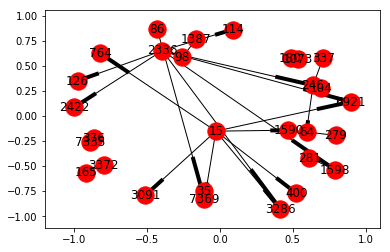



{'#nodes': 18, 'betweenness': 0.0004084967320261438, 'weights max': 3.0, 'eigenvector': 0.07945058438744261, '#pos edges': 12, 'in_degree': 0.0457516339869281, 'weights std': 2.9906316307797605, 'clustering_coefficient': 1369.5555555555557, '#edges': 14, 'closeness': 0.04738562091503268, 'degree': 0.0915032679738562, '#neg edges': 2, 'harmonic': 0.8333333333333334, '#gcc pos edges': 9, 'weights min': -10.0, 'load': 0.0004084967320261438, 'weights mean': 0.35714285714285715, 'gcc': 10, '#edges/#nodes': 0.7777777777777778, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.0457516339869281}


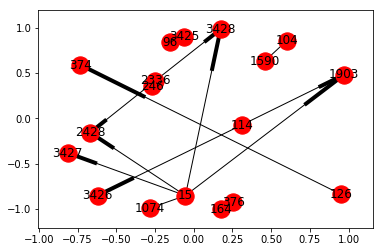



{'#nodes': 16, 'betweenness': 0.00505952380952381, 'weights max': 10.0, 'eigenvector': 0.06349500126601401, '#pos edges': 16, 'in_degree': 0.06666666666666668, 'weights std': 2.179449471770337, 'clustering_coefficient': 767.875, '#edges': 16, 'closeness': 0.0810515873015873, 'degree': 0.13333333333333336, '#neg edges': 0, 'harmonic': 1.3645833333333333, '#gcc pos edges': 15, 'weights min': 1.0, 'load': 0.00505952380952381, 'weights mean': 2.0, 'gcc': 14, '#edges/#nodes': 1.0, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.06666666666666667}


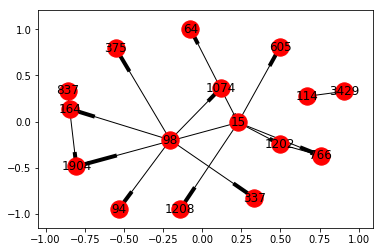



{'#nodes': 47, 'betweenness': 0.01818275259533354, 'weights max': 10.0, 'eigenvector': 0.11502623202621863, '#pos edges': 76, 'in_degree': 0.036540240518038856, 'weights std': 2.645054761844856, 'clustering_coefficient': 1443.8936170212767, '#edges': 79, 'closeness': 0.11598051160540283, 'degree': 0.07308048103607771, '#neg edges': 3, 'harmonic': 6.577406281661601, '#gcc pos edges': 66, 'weights min': -10.0, 'load': 0.01818275259533354, 'weights mean': 1.6962025316455696, 'gcc': 44, '#edges/#nodes': 1.6808510638297873, 'algebraic_connectivity': 0.0, '#gcc neg edges': 3, 'out_degree': 0.036540240518038856}


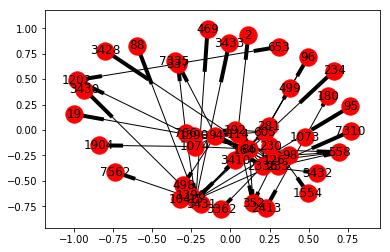



{'#nodes': 31, 'betweenness': 0.001668520578420467, 'weights max': 10.0, 'eigenvector': 0.08555448370951696, '#pos edges': 24, 'in_degree': 0.03333333333333334, 'weights std': 3.3684587050855774, 'clustering_coefficient': 1889.258064516129, '#edges': 31, 'closeness': 0.04260712528739095, 'degree': 0.0666666666666667, '#neg edges': 7, 'harmonic': 1.435483870967742, '#gcc pos edges': 21, 'weights min': -10.0, 'load': 0.001668520578420467, 'weights mean': 0.4838709677419355, 'gcc': 23, '#edges/#nodes': 1.0, 'algebraic_connectivity': 0.0, '#gcc neg edges': 5, 'out_degree': 0.03333333333333334}


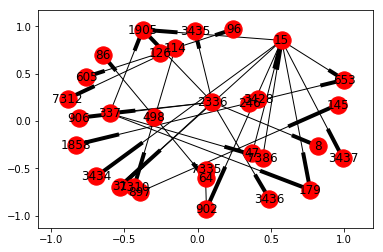



{'#nodes': 32, 'betweenness': 0.007123655913978495, 'weights max': 4.0, 'eigenvector': 0.10784223941050584, '#pos edges': 34, 'in_degree': 0.035282258064516125, 'weights std': 0.7591617288906527, 'clustering_coefficient': 1457.65625, '#edges': 35, 'closeness': 0.05556044104381154, 'degree': 0.07056451612903225, '#neg edges': 1, 'harmonic': 2.0557291666666666, '#gcc pos edges': 30, 'weights min': -1.0, 'load': 0.007123655913978495, 'weights mean': 1.2285714285714286, 'gcc': 29, '#edges/#nodes': 1.09375, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.035282258064516125}


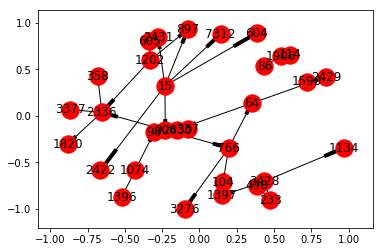



{'#nodes': 25, 'betweenness': 0.002028985507246377, 'weights max': 3.0, 'eigenvector': 0.09865689434731167, '#pos edges': 24, 'in_degree': 0.04166666666666666, 'weights std': 0.7525955088890712, 'clustering_coefficient': 1297.08, '#edges': 25, 'closeness': 0.050582010582010575, 'degree': 0.08333333333333334, '#neg edges': 1, 'harmonic': 1.35, '#gcc pos edges': 19, 'weights min': -1.0, 'load': 0.002028985507246377, 'weights mean': 1.44, 'gcc': 21, '#edges/#nodes': 1.0, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.04166666666666666}


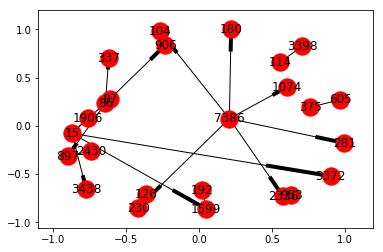



{'#nodes': 20, 'betweenness': 0.00029239766081871346, 'weights max': 6.0, 'eigenvector': 0.07166974576115238, '#pos edges': 15, 'in_degree': 0.04473684210526315, 'weights std': 1.600173001027699, 'clustering_coefficient': 1606.6, '#edges': 17, 'closeness': 0.046271929824561395, 'degree': 0.08947368421052629, '#neg edges': 2, 'harmonic': 0.9, '#gcc pos edges': 8, 'weights min': -2.0, 'load': 0.00029239766081871346, 'weights mean': 1.2941176470588236, 'gcc': 10, '#edges/#nodes': 0.85, 'algebraic_connectivity': 0.0, '#gcc neg edges': 2, 'out_degree': 0.04473684210526315}


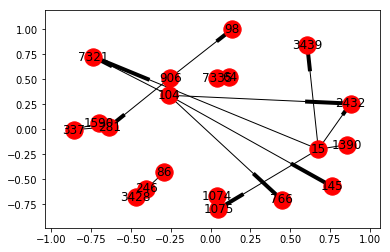



{'#nodes': 27, 'betweenness': 0.00034188034188034193, 'weights max': 4.0, 'eigenvector': 0.09072257277763247, '#pos edges': 21, 'in_degree': 0.03276353276353276, 'weights std': 0.9465887416120539, 'clustering_coefficient': 1539.9259259259259, '#edges': 23, 'closeness': 0.03537511870845204, 'degree': 0.06552706552706554, '#neg edges': 2, 'harmonic': 0.9629629629629629, '#gcc pos edges': 12, 'weights min': -1.0, 'load': 0.00034188034188034193, 'weights mean': 1.1304347826086956, 'gcc': 14, '#edges/#nodes': 0.8518518518518519, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.03276353276353276}


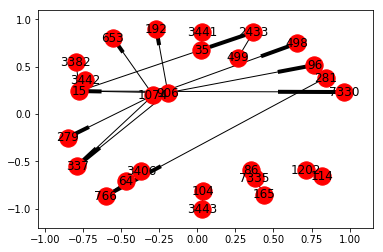



{'#nodes': 20, 'betweenness': 0.006725146198830409, 'weights max': 3.0, 'eigenvector': 0.12656982667575475, '#pos edges': 19, 'in_degree': 0.05263157894736842, 'weights std': 0.792148975887743, 'clustering_coefficient': 1996.25, '#edges': 20, 'closeness': 0.0666593237045182, 'degree': 0.10526315789473684, '#neg edges': 1, 'harmonic': 1.465833333333333, '#gcc pos edges': 12, 'weights min': -1.0, 'load': 0.006725146198830409, 'weights mean': 1.35, 'gcc': 13, '#edges/#nodes': 1.0, 'algebraic_connectivity': 0.0, '#gcc neg edges': 1, 'out_degree': 0.05263157894736842}


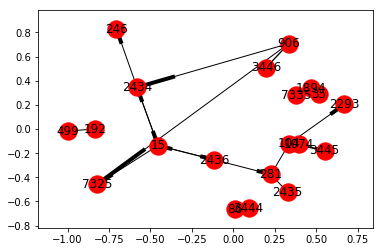



{'#nodes': 9, 'betweenness': 0.001984126984126984, 'weights max': 3.0, 'eigenvector': 0.11216189457020513, '#pos edges': 6, 'in_degree': 0.08333333333333333, 'weights std': 0.816496580927726, 'clustering_coefficient': 936.2222222222222, '#edges': 6, 'closeness': 0.08796296296296297, 'degree': 0.16666666666666666, '#neg edges': 0, 'harmonic': 0.7222222222222222, '#gcc pos edges': 3, 'weights min': 1.0, 'load': 0.001984126984126984, 'weights mean': 2.0, 'gcc': 4, '#edges/#nodes': 0.6666666666666666, 'algebraic_connectivity': 0.0, '#gcc neg edges': 0, 'out_degree': 0.08333333333333333}


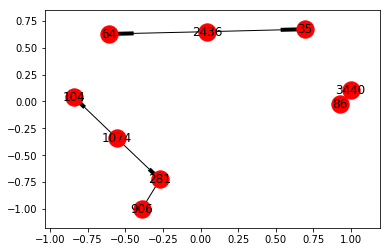



{'#nodes': 26, 'betweenness': 0.0022435897435897434, 'weights max': 10.0, 'eigenvector': 0.11752631521663913, '#pos edges': 17, 'in_degree': 0.038461538461538464, 'weights std': 3.9508986319570387, 'clustering_coefficient': 1621.5, '#edges': 25, 'closeness': 0.05034319526627219, 'degree': 0.07692307692307693, '#neg edges': 8, 'harmonic': 1.3814102564102566, '#gcc pos edges': 7, 'weights min': -10.0, 'load': 0.0022435897435897434, 'weights mean': 1.48, 'gcc': 10, '#edges/#nodes': 0.9615384615384616, 'algebraic_connectivity': 0.0, '#gcc neg edges': 3, 'out_degree': 0.038461538461538464}


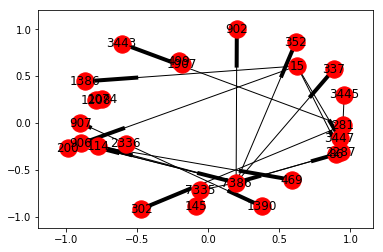

In [8]:
weeks = 4

start_date = min(data['time'])
end_date = max(data['time'])

positives = []
negatives = []
gcc_positives = []
gcc_negatives = []

periods_num = int(np.floor((end_date - start_date).days / (weeks * 7)))
# For every period, we extract a directed weighted signed network.
for period_index in range(periods_num):
    period_start = (
        start_date + period_index * datetime.timedelta(weeks * 7))
    period_end = period_start + datetime.timedelta(weeks * 7)
    # Chooses the data only for this period.
    period_data = data[
        (data['time'] >= period_start) &
        (data['time'] < period_end)]
    directed_graph = nx.from_pandas_edgelist(
        period_data,
        source='source',
        target='target',
        edge_attr='weight',
        create_using=nx.DiGraph())
    nx.draw_networkx(directed_graph)
    metrics = get_metrics_for_network(directed_graph)
    print(metrics)
    plt.show()
    print('\n')
    
    positives.append(metrics['#pos edges'])
    negatives.append(metrics['#neg edges'])
    gcc_positives.append(metrics['#gcc pos edges'])
    gcc_negatives.append(metrics['#gcc neg edges'])

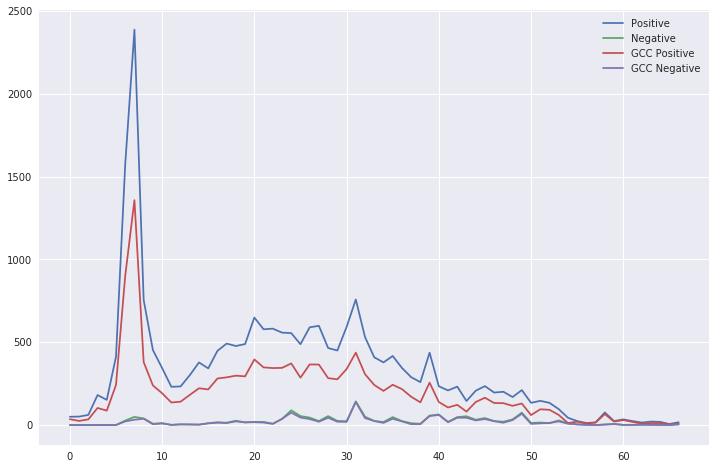

In [9]:
sns.set(rc={'figure.figsize':(12, 8)})
plt.plot(positives)
plt.plot(negatives)
plt.plot(gcc_positives)
plt.plot(gcc_negatives)
plt.legend(['Positive', 'Negative', 'GCC Positive', 'GCC Negative']);

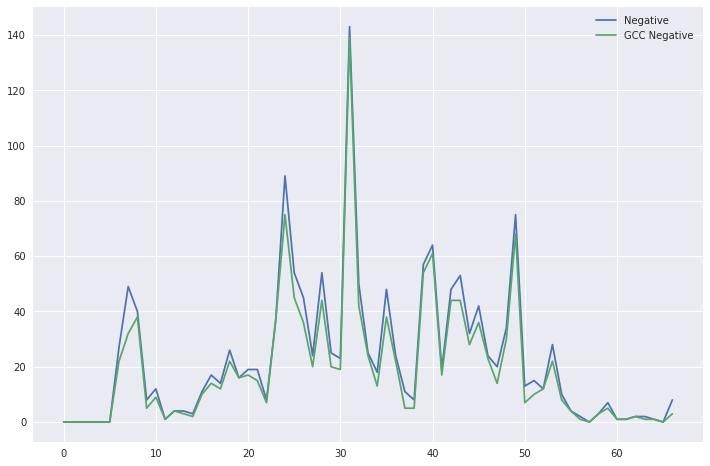

In [10]:
plt.plot(negatives)
plt.plot(gcc_negatives)
plt.legend(['Negative', 'GCC Negative']);

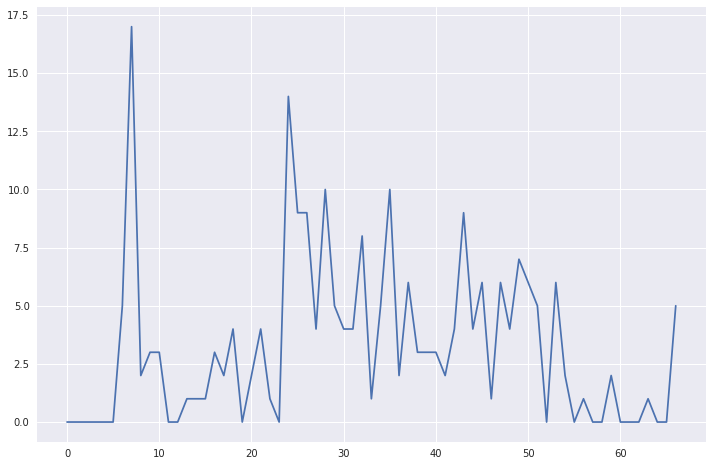

In [11]:
plt.plot(np.array(negatives) - np.array(gcc_negatives));